In [1]:
# general purpose python
import collections
import datetime
import glob
import hashlib
import importlib
import itertools
import json
import math
import os
import pickle
import random
import re
import shutil
import sys
import time
import warnings

# general purpose data science
import IPython
import ipywidgets as ipw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

# computer vision
import cv2
import imageio
import PIL
from PIL import *

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('pytorch device:    ', device)

# geospatial
import rasterio as rio
import rasterio.features

ignore_warnings = True
if ignore_warnings:
    warnings.filterwarnings('ignore')
print('ignore warnings:   ', ignore_warnings)

seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
print('random seed:       ', seed)

mpl.rcParams['figure.dpi'] = 200

IPython.core.display.display(IPython.core.display.HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_colwidth = 32
pd.options.display.float_format = '{:,.6f}'.format
pd.options.display.expand_frame_repr = False

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

plotly.offline.init_notebook_mode(connected=True)
plotly.io.templates.default = 'plotly_white'

_ = torch.autograd.set_detect_anomaly(False)

pytorch device:     cuda
ignore warnings:    True
random seed:        1337


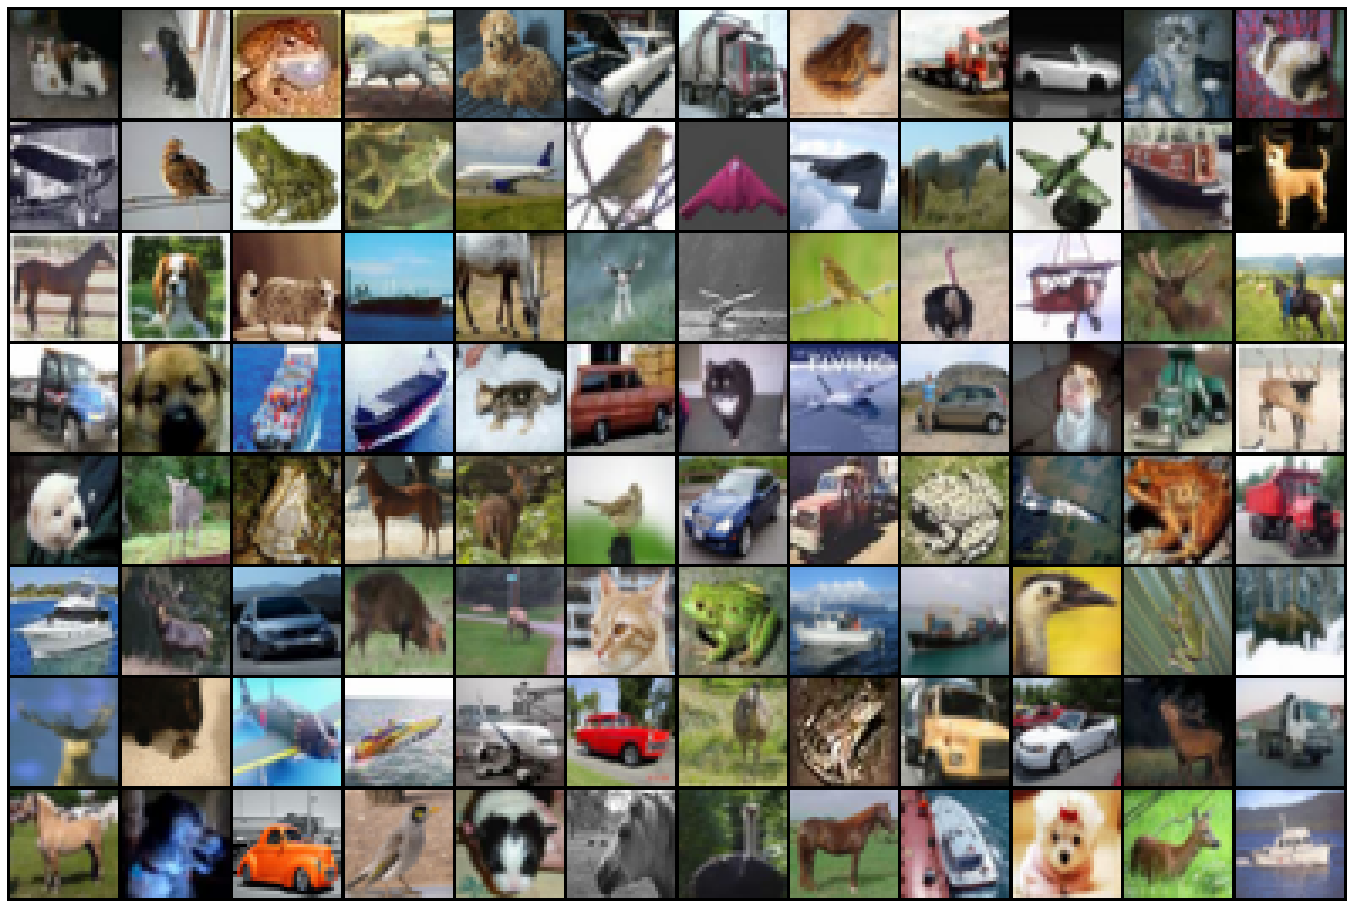

In [2]:
# create data loader
def get_data_loader(train, batch_size):
    img_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5))])
    dataset = torchvision.datasets.CIFAR10(
        root='/media/ntfs/data/torchvision_root',
        train=train,
        transform=img_transform)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=16,
        pin_memory=True)
    
    return data_loader

train_loader = get_data_loader(train=True,
                               batch_size=128)
test_loader = get_data_loader(train=False,
                               batch_size=128)

classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck')

# take a look at some samples
batch = next(iter(train_loader))

plt.figure(figsize=(24,24))
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            batch[0][:8*12],
            nrow=12,
            padding=1,
            normalize=True),(1,2,0)))
plt.axis('off')
plt.show()

In [3]:
# for debugging module size issues
class PrintShape(nn.Module):
    def __init__(self, label):
        super(PrintShape, self).__init__()
        self.label = label

    def forward(self, x):
        print(self.label, x.shape)
        return x


class ConvClassifier(nn.Module):
    def __init__(self,
                 n_output_dim=2,
                 n_conv_layers=2,
                 n_feature_maps=16,
                 feature_map_multiplier=2,
                 n_dense_layers=2,
                 n_dense_neurons=64,
                 dropout=0.0,
                 n_input_channels=3,
                 relu_slope=0.01,
                 bias=False):
        super(ConvClassifier, self).__init__()
        
        self.n_output_dim = n_output_dim
        self.n_conv_layers = n_conv_layers
        self.n_feature_maps = n_feature_maps
        self.feature_map_multiplier = feature_map_multiplier
        self.n_dense_layers = n_dense_layers
        self.n_dense_neurons = n_dense_neurons
        self.dropout = dropout
        self.n_input_channels = n_input_channels
        self.relu_slope = relu_slope
        self.bias = bias
        
        modules = [
            nn.Conv2d(in_channels=self.n_input_channels,
                      out_channels=self.n_feature_maps,
                      kernel_size=5,
                      stride=1,
                      padding=2,
                      bias=False),
            nn.BatchNorm2d(num_features=self.n_feature_maps),
            nn.LeakyReLU(negative_slope=self.relu_slope,
                         inplace=True),
            nn.Conv2d(in_channels=self.n_feature_maps,
                      out_channels=self.n_feature_maps,
                      kernel_size=2,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(num_features=self.n_feature_maps),
            nn.LeakyReLU(negative_slope=self.relu_slope,
                         inplace=True)]
                        
        n_fm = self.n_feature_maps
        for i in range(self.n_conv_layers-1):
            modules.append(
                nn.Conv2d(
                    in_channels=n_fm,
                    out_channels=n_fm * self.feature_map_multiplier,
                    kernel_size=5,
                    stride=1,
                    padding=2,
                    bias=False))
            modules.append(
                nn.BatchNorm2d(
                    num_features=n_fm * self.feature_map_multiplier))
            modules.append(
                nn.LeakyReLU(
                    negative_slope=self.relu_slope,
                    inplace=True))
            modules.append(
                nn.Conv2d(in_channels=n_fm * self.feature_map_multiplier,
                          out_channels=n_fm * self.feature_map_multiplier,
                          kernel_size=2,
                          stride=2,
                          padding=0,
                          bias=False))
            modules.append(
                nn.BatchNorm2d(num_features=n_fm * self.feature_map_multiplier))
            modules.append(
                nn.LeakyReLU(negative_slope=self.relu_slope,
                             inplace=True))
            n_fm *= self.feature_map_multiplier
        
        modules.append(nn.Flatten())
        
        modules.append(
            nn.Linear(
                in_features=int((32/(2**self.n_conv_layers))**2 * n_fm),
                out_features=n_output_dim if self.n_dense_layers == 0 else self.n_dense_neurons,
                bias=self.bias))
        
        if self.n_dense_layers > 0:
            for i in range(self.n_dense_layers - 1):
                modules.append(
                    nn.LeakyReLU(
                        negative_slope=self.relu_slope,
                        inplace=True))
                modules.append(
                    nn.Dropout(
                        self.dropout))
                modules.append(
                    nn.Linear(
                        in_features=self.n_dense_neurons,
                        out_features=self.n_dense_neurons,
                        bias=self.bias))
            modules.append(
                nn.LeakyReLU(
                    negative_slope=self.relu_slope,
                    inplace=True))
            modules.append(
                nn.Dropout(
                    self.dropout))
            modules.append(
                nn.Linear(
                    in_features=self.n_dense_neurons,
                    out_features=self.n_output_dim,
                    bias=self.bias))
        
        modules = collections.OrderedDict(zip([f'layer_{i:03d}' for i in range(len(modules))], modules))
        self.main = nn.Sequential(modules)

    def forward(self, x):
        y = self.main(x)
        return y

    def get_hyperparams(self):
        hyperparams = collections.OrderedDict()
        hyperparams['n_output_dim'] = self.n_output_dim
        hyperparams['n_conv_layers'] = self.n_conv_layers
        hyperparams['n_feature_maps'] = self.n_feature_maps
        hyperparams['feature_map_multiplier'] = self.feature_map_multiplier
        hyperparams['n_dense_layers'] = self.n_dense_layers
        hyperparams['n_dense_neurons'] = self.n_dense_neurons
        hyperparams['dropout'] = self.dropout
        hyperparams['n_input_channels'] = self.n_input_channels
        hyperparams['relu_slope'] = self.relu_slope
        hyperparams['bias'] = self.bias
        return hyperparams


# create an instance
m = ConvClassifier(
    n_output_dim=10,
    n_conv_layers=2,
    n_feature_maps=32,
    feature_map_multiplier=1,
    n_dense_layers=3,
    n_dense_neurons=64,
    dropout=0.5,
    n_input_channels=3,
    relu_slope=0.1,
    bias=False).to(device)
print(m)
print(m.get_hyperparams())

# make sure that the input/output sizes are correct
x = torch.rand(128 * 3 * 32 * 32, device=torch.device('cuda')).view(128, 3, 32, 32)
print('input shape:  ', x.shape)
y = m.forward(x)
print('output shape: ', y.shape)
print(y.dtype)

ConvClassifier(
  (main): Sequential(
    (layer_000): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (layer_001): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_002): LeakyReLU(negative_slope=0.1, inplace=True)
    (layer_003): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (layer_004): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_005): LeakyReLU(negative_slope=0.1, inplace=True)
    (layer_006): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (layer_007): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_008): LeakyReLU(negative_slope=0.1, inplace=True)
    (layer_009): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (layer_010): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_011): LeakyReLU(negative_slope=0.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        modules = [
            nn.Conv2d(3, 16, 5),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            
            nn.Conv2d(16, 16, 2, 2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            
            nn.Conv2d(16, 32, 5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 32, 2, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Flatten(),
            
            nn.Linear(32 * 5 * 5, 128),
            nn.LeakyReLU(),
                        
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            
            nn.Linear(128, 10)]
        modules = collections.OrderedDict(zip([f'layer_{i:03d}' for i in range(len(modules))], modules))
        self.main = nn.Sequential(modules)

    def forward(self, x):
        return self.main(x)
    
    def get_hyperparams(self):
        return collections.OrderedDict()

In [5]:
def evaluate_model(
    batch_size,
    n_output_dim,
    n_conv_layers,
    n_feature_maps,
    feature_map_multiplier,
    n_dense_layers,
    n_dense_neurons,
    dropout,
    n_input_channels,
    relu_slope,
    bias,
    n_epochs,
    learning_rate,
    weight_decay):
    
    model = ConvClassifier(
        n_output_dim=n_output_dim,
        n_conv_layers=n_conv_layers,
        n_feature_maps=n_feature_maps,
        feature_map_multiplier=feature_map_multiplier,
        n_dense_layers=n_dense_layers,
        n_dense_neurons=n_dense_neurons,
        dropout=dropout,
        n_input_channels=n_input_channels,
        relu_slope=relu_slope,
        bias=bias).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.5, 0.999))
    
    train_loader = get_data_loader(train=True,
                                  batch_size=batch_size)
    test_loader = get_data_loader(train=False,
                                  batch_size=batch_size)

    train_loss_history = []
    test_loss_history = []
    start_ts = datetime.datetime.now()
    print(start_ts.strftime('%H:%M:%S'))
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            for param in model.parameters():
                param.grad = None
            x, y_true = data
            x = x.to(device)
            y_true = y_true.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y_true)
            train_loss += loss
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
            
        test_loss = 0.0
        for i, data in enumerate(test_loader, 0):
            with torch.no_grad():
                x, y_true = data
                x = x.to(device)
                y_true = y_true.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y_true)
                test_loss += loss
        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)
            
        print('{1}{0}epoch: {2:03d}/{3:03d}{0}batch: {4:05d}/{5:05d}{0}train loss: {6:0.4f}{0}test loss: {7:0.4f}'.format(
                    '        ',
                    datetime.datetime.now().strftime('%H:%M:%S'),
                    epoch,
                    n_epochs,
                    i,
                    len(train_loader),
                    train_loss,
                    test_loss))

    training_time = int((datetime.datetime.now() - start_ts).total_seconds())
    
    last_train_loss = train_loss_history[-1]
    min_train_loss = min(train_loss_history)
    last_test_loss = test_loss_history[-1]
    min_test_loss = min(test_loss_history)
    
    results = model.get_hyperparams()
    results['batch_size'] = batch_size
    results['n_epochs'] = n_epochs
    results['learning_rate'] = learning_rate
    results['weight_decay'] = weight_decay
    
    file_name = f'img_classif_hyperparam_opt_result_{hashlib.sha1(str(results).encode("utf-8")).hexdigest()[:8]}.json'
#     print(file_name)
    
    results['last_train_loss'] = round(last_train_loss.item(), 4)
    results['min_train_loss'] = round(min_train_loss.item(), 4)
    results['last_test_loss'] = round(last_test_loss.item(), 4)
    results['min_test_loss'] = round(min_test_loss.item(), 4)
    results['training_time'] = training_time
    
    with open(file_name, 'w') as f:
        f.write(json.dumps(results))
    
#     for k in results.keys():
#         print(f'{k:40}', results[k])
    
#     plt.figure(figsize=(10, 5))
#     x_scale = np.linspace(1, n_epochs, len(train_loss_history))
#     plt.plot(x_scale,
#              train_loss_history,
#              c='b',
#              linewidth=1,
#              marker='.',
#              label='Train loss')
#     plt.plot(x_scale,
#              test_loss_history,
#              c='r',
#              linewidth=1,
#              marker='.',
#              label='Test loss')
#     plt.xticks(range(0, n_epochs + 1))
#     plt.xlim(1, n_epochs)
#     plt.ylim(0, None)
#     plt.legend()
#     plt.show()


# evaluate_model(
#     batch_size=256,
#     n_output_dim=10,
#     n_conv_layers=2,
#     n_feature_maps=16,
#     feature_map_multiplier=2,
#     n_dense_layers=2,
#     n_dense_neurons=128,
#     dropout=0.0,
#     n_input_channels=3,
#     relu_slope=0.1,
#     bias=False,
#     n_epochs=2,
#     learning_rate=0.003,
#     weight_decay=1e-5)

In [6]:
i = 1
for batch_size in [32, 64, 128]:
    for learning_rate in [0.003, 0.001, 0.0003]:
        for n_conv_layers in [2]:
            for n_feature_maps in [16, 32, 64]:
                for feature_map_multiplier in [1]:
                    for n_dense_layers in [1]:
                        for n_dense_neurons in [128]:
                            if i <= 0:
                                print('skip')
                            else:
                                print(i)
                                evaluate_model(
                                    batch_size=batch_size,
                                    n_output_dim=10,
                                    n_conv_layers=n_conv_layers,
                                    n_feature_maps=n_feature_maps,
                                    feature_map_multiplier=feature_map_multiplier,
                                    n_dense_layers=n_dense_layers,
                                    n_dense_neurons=n_dense_neurons,
                                    dropout=0.0,
                                    n_input_channels=3,
                                    relu_slope=0.1,
                                    bias=False,
                                    n_epochs=5,
                                    learning_rate=learning_rate,
                                    weight_decay=1e-5)
                            i +=1

1
15:06:17
15:06:24        epoch: 001/005        batch: 00312/01563        train loss: 1.3709        test loss: 1.1557
15:06:32        epoch: 002/005        batch: 00312/01563        train loss: 1.0098        test loss: 0.9814
15:06:39        epoch: 003/005        batch: 00312/01563        train loss: 0.8400        test loss: 0.9018
15:06:46        epoch: 004/005        batch: 00312/01563        train loss: 0.7239        test loss: 0.8985
15:06:53        epoch: 005/005        batch: 00312/01563        train loss: 0.6340        test loss: 0.9085
2
15:06:54
15:07:01        epoch: 001/005        batch: 00312/01563        train loss: 1.3327        test loss: 1.2508
15:07:08        epoch: 002/005        batch: 00312/01563        train loss: 0.9292        test loss: 0.9032
15:07:15        epoch: 003/005        batch: 00312/01563        train loss: 0.7508        test loss: 0.8257
15:07:23        epoch: 004/005        batch: 00312/01563        train loss: 0.6167        test loss: 0.8404
15:07:

15:14:55
15:15:00        epoch: 001/005        batch: 00156/00782        train loss: 1.4460        test loss: 1.2948
15:15:05        epoch: 002/005        batch: 00156/00782        train loss: 1.1739        test loss: 1.1692
15:15:10        epoch: 003/005        batch: 00156/00782        train loss: 1.0546        test loss: 1.0894
15:15:15        epoch: 004/005        batch: 00156/00782        train loss: 0.9713        test loss: 1.0443
15:15:20        epoch: 005/005        batch: 00156/00782        train loss: 0.9028        test loss: 1.0401
17
15:15:21
15:15:26        epoch: 001/005        batch: 00156/00782        train loss: 1.3506        test loss: 1.2012
15:15:31        epoch: 002/005        batch: 00156/00782        train loss: 1.0133        test loss: 1.0216
15:15:36        epoch: 003/005        batch: 00156/00782        train loss: 0.8563        test loss: 0.9076
15:15:41        epoch: 004/005        batch: 00156/00782        train loss: 0.7441        test loss: 0.8767
15:15:4

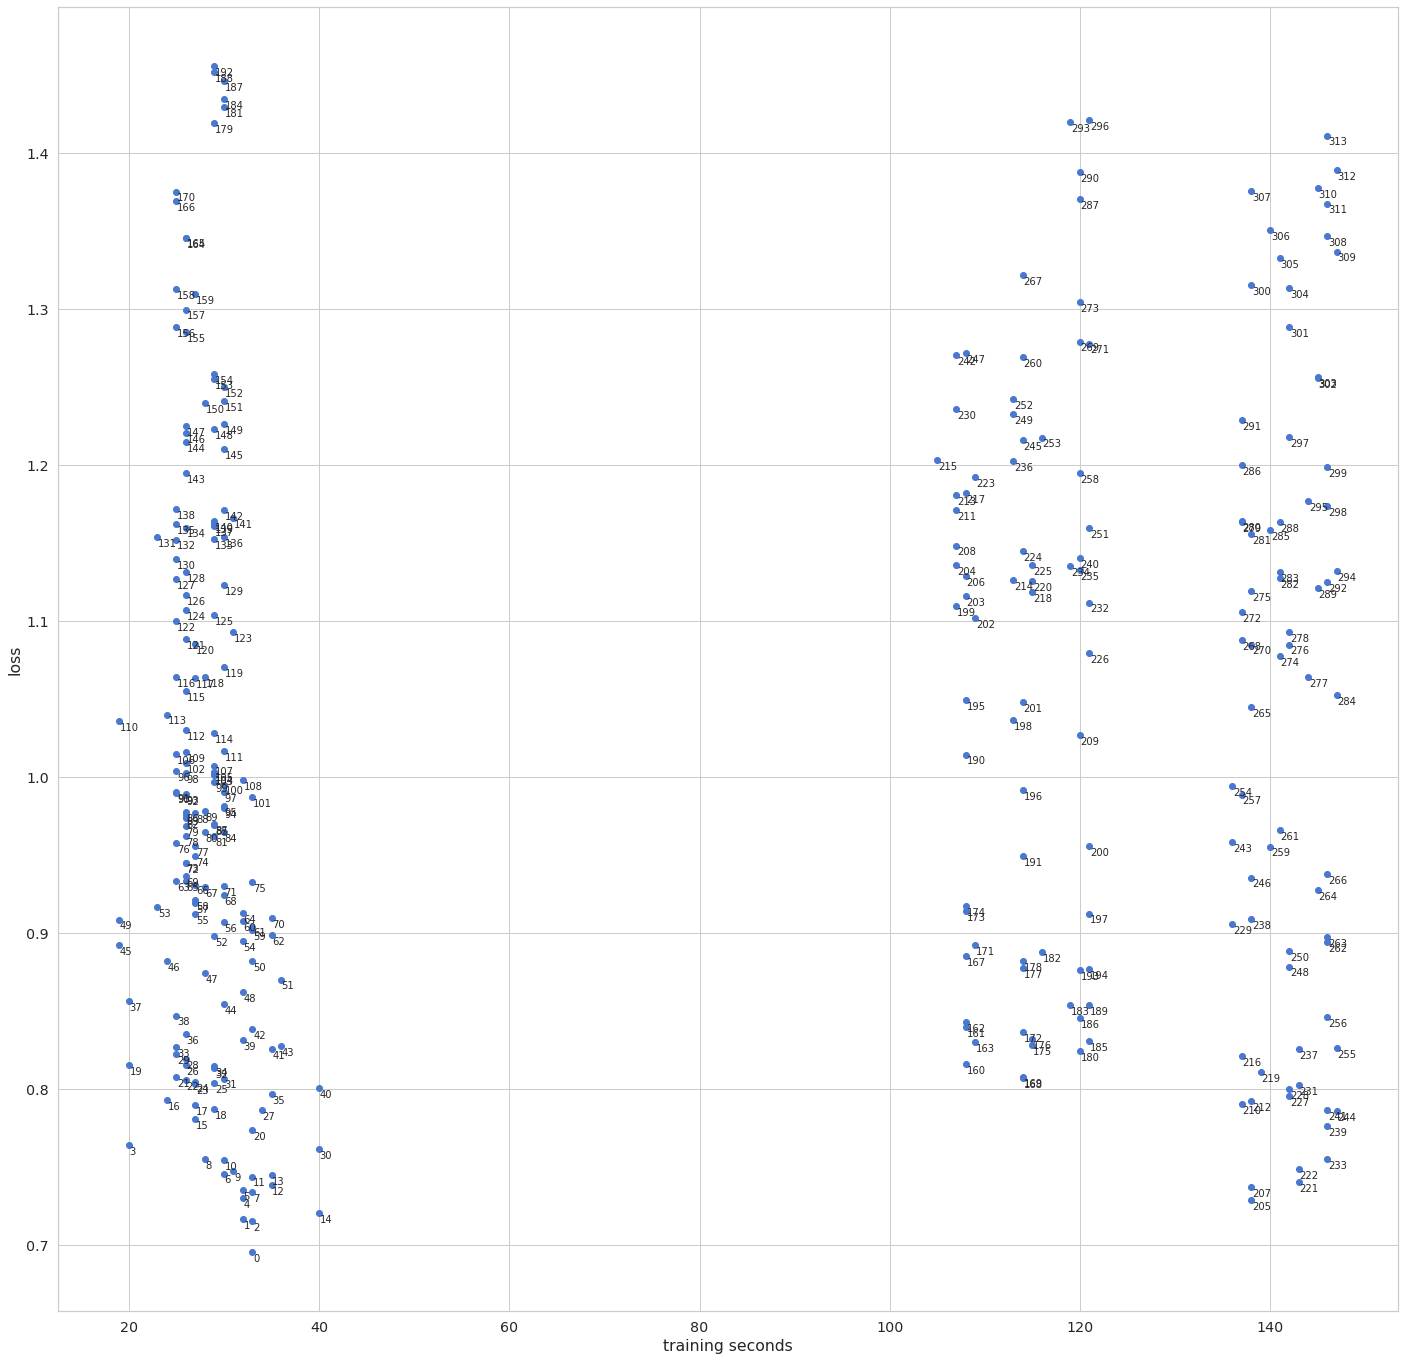

Combined order
    batch_size  n_conv_layers  n_f_maps  f_map_mul  n_dense_layers  n_dense_neurons  learning_rate  min_train_loss  min_test_loss  training_time  time_rnk  loss_rnk  comb_rnk
0           64              3        32          2               2              128       0.001000        0.497000       0.695500             33       153         1         1
1           64              3        32          2               1               32       0.001000        0.498200       0.716400             32       143         3         2
2           64              3        32          2               2               32       0.001000        0.540900       0.715100             33       153         2         3
3          128              2        32          1               1              128       0.001000        0.544200       0.763900             20         5        21         4
4           64              3        32          2               1              128       0.001000        0.46

In [23]:
performances = []
for file_name in glob.glob('img_classif_hyperparam_opt_result_*.json'):
    with open(file_name) as f:
        performances.append(json.loads(f.read()))
performances = pd.DataFrame(performances)[[
    'batch_size',
    'n_conv_layers',
    'n_feature_maps',
    'feature_map_multiplier',
    'n_dense_layers',
    'n_dense_neurons',
    'learning_rate',
    'min_train_loss',
    'min_test_loss',
    'training_time']]
performances.columns = [
    'batch_size',
    'n_conv_layers',
    'n_f_maps',
    'f_map_mul',
    'n_dense_layers',
    'n_dense_neurons',
    'learning_rate',
    'min_train_loss',
    'min_test_loss',
    'training_time']
performances['combined'] = np.power(np.power(performances['training_time'].tolist(), 2) +  np.power((100 * performances['min_test_loss']).tolist(), 2), 0.5)
performances['time_rnk'] = performances.training_time.rank().astype(int)
performances['loss_rnk'] = performances.min_test_loss.rank().astype(int)
performances['comb_rnk'] = performances.combined.rank().astype(int)
del performances['combined']
performances.sort_values(by=['comb_rnk'], inplace=True)
performances.index = range(len(performances))

#performances = performances[performances.index < 64]

fig, ax = plt.subplots(figsize=(24, 24))
plt.scatter(
    performances.training_time,
    performances.min_test_loss)

for i in range(len(performances)):
    ax.annotate(
        str(i),
        (performances.training_time.tolist()[i] + 0.07, performances.min_test_loss.tolist()[i] - 0.006),
        fontsize=10)

#plt.xlim((0, 120))
#plt.ylim((0, 1.2))
plt.xlabel('training seconds')
plt.ylabel('loss')
plt.show()

print('Combined order')
print(performances.sort_values(by=['comb_rnk']).head(50))

print('Loss order')
print(performances.sort_values(by=['loss_rnk']).head(50))
print()

print('Time order')
print(performances.sort_values(by=['time_rnk']).head(50))
print()